In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
benchmark = pd.read_csv('mae-benchmark.csv')
benchmark = benchmark.melt(id_vars=['LOT/BS'], var_name='solvation model', value_name='MAE (V)')
benchmark['LOT/BS'] = benchmark['LOT/BS'].str.replace('⍵', r'$\omega$')

In [3]:
benchmark

,LOT/BS,solvation model,MAE (V)
0,B3LYP-D3/6-31G**,CPCM,0.35
1,B3LYP-D3/6-31+G**,CPCM,0.19
2,B3LYP-D3/def2tzvp,CPCM,0.18
3,M062X/6-31G**,CPCM,0.22
4,M062X/6-31+G**,CPCM,0.20
5,M062X/def2tzvp,CPCM,0.19
6,$\omega$B97XD/6-31G**,CPCM,0.28
7,$\omega$B97XD/6-31+G**,CPCM,0.16
8,$\omega$B97XD/def2tzvp,CPCM,0.15
9,CAM-B3LYP/def2tzvp,CPCM,0.15


In [4]:
lr_redox = pd.read_csv('learning_curve_ie_ea.csv', index_col=0)
lr_stab = pd.read_csv('learning_curve_spin_bv.csv', index_col=0)
redox_test = pd.read_csv('test-set-redox-dft-vs-ml.csv.gz', index_col=0)

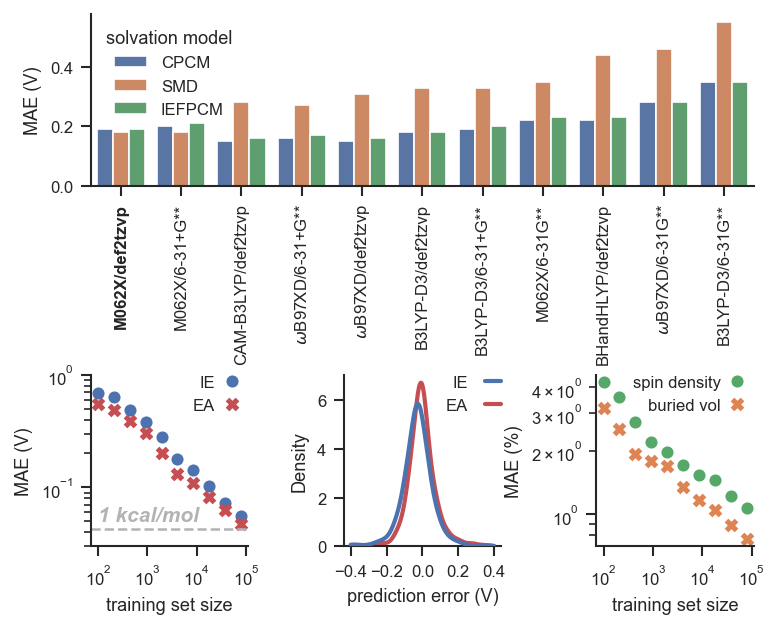

In [5]:
fig = plt.figure(figsize=(5,4), dpi=150)
gs = fig.add_gridspec(2, 3)

ax = fig.add_subplot(gs[0, :])
sns.barplot(x='LOT/BS', hue='solvation model', y='MAE (V)', data=benchmark, ax=ax,
            order=benchmark.groupby('LOT/BS')['MAE (V)'].mean().sort_values().index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
label = ax.get_xticklabels()[0]
label.set_fontweight('bold')
ax.set_xlabel(None)


ax2 = fig.add_subplot(gs[1, 0])
ax2.loglog(lr_redox['num_train'], lr_redox['mae_ie'], 'o', label='IE')
ax2.loglog(lr_redox['num_train'], lr_redox['mae_ea'], 'x', color='r', markeredgewidth=2.5, label='EA')
ax2.axhline(0.043, ls='--', color='.7')
ax2.text(lr_redox['num_train'].min(), 0.05, '1 kcal/mol', color='.7', style='italic', weight='bold')
ax2.legend(loc='upper right', markerfirst=False, borderpad=0, borderaxespad=0, handletextpad=0, handlelength=2)

ax2.set_ylabel('MAE (V)')
ax2.set_ylim([.03, 1.])
ax2.set_xticks([100, 1000, 10000, 100000])
ax2.set_xlabel('training set size')

ax4 = fig.add_subplot(gs[1, 1])
sns.kdeplot(redox_test['pred ionization energy'] - redox_test['ionization energy'], clip=[-.4, .4], ax=ax4, color='b', label='IE', lw=2, zorder=5)
sns.kdeplot(redox_test['pred electron affinity'] - redox_test['electron affinity'], clip=[-.4, .4], ax=ax4, color='r', label='EA', lw=2)
ax4.legend(loc='upper right', markerfirst=False, borderpad=0, borderaxespad=0, handletextpad=1, handlelength=1)
ax4.set_xlabel('prediction error (V)')
ax4.set_xticks([-.4, -.2, 0., .2, .4])


ax3 = fig.add_subplot(gs[1, 2])
ax3.loglog(lr_stab['num_train'], lr_stab['mae_spin'] * 100, 'o', color=sns.color_palette()[2], label='spin density')
ax3.loglog(lr_stab['num_train'], lr_stab['mae_bv'], 'x', color=sns.color_palette()[1], markeredgewidth=2.5, label='buried vol')
ax3.legend(loc='upper right', markerfirst=False, borderpad=0, borderaxespad=0, handletextpad=0, handlelength=2)
ax3.set_ylabel('MAE (%)')
ax3.set_xticks([100, 1000, 10000, 100000])
ax3.set_xlabel('training set size')



sns.despine()
fig.tight_layout(pad=0)
plt.savefig('fig2_surrogate_model.svg')